# 0. Marking.

***IMPORTANT***: Save a copy of this notebook into your Drive before you start.
- Please attempt all the questions marked for your group (Part II ✅ | Part III/MPhil ✅).

Please submit a zip file, containing both parts, consiting of of:
1. A text file with a publicly visible link to your notebooks in Google Colab or GitHub.
2. A downloaded copy (ipynb) of your notebooks or your zipped cloned GitHub repo. You may treat these as a report: we will not be re-executing the code you used to produce the answers unless required.

If you find yourself enjoying the material, feel free to attempt more! Provide your answers in a new cell below the question cell.

# 1. Introduction


Welcome to the third lab session in our FL course.
We now know how to “federate” a centralised ML model and have learned some tools to deal with data heterogeneity.

During this session, we will try to put our hands on system heterogeneity in simulating FL. However, assuming you want to produce an FL system that will be deployed in the real world, taking into account data heterogeneity is often not enough.

Client hardware may be correlated with the underlying data---e.g. a smartphone's camera impacts image characteristics---or with which data is used. For example, clients with less reliable internet connections from specific regions of the world are more likely to drop out, making their region underrepresented in training. Thus, the limits placed on computation time or the assumptions made in applying a synchronous or asynchronous algorithm affect model performance, fairness, or scalability.

Developers may want to simulate their FL pipelines in a controlled environment in which natural system characteristics are modelled in order to be able to understand such trade-offs.

What should we take into account, then?
Clients' availability, training time, communication bandwidth, and other factors sometimes impact natural FL systems unexpectedly.
Developers usually set up constraints for selecting clients to account for most of these factors, but in the worst case, these may result in not completing even a single round.
On the other hand, relaxing some constraints produces long round completion times, and eventually, the FL model cannot reach convergence in a reasonable interval.

Before we begin modelling such concerns, we shall investigate data regarding real-world system characteristics from the two following papers:

1. [Papaya: Practical, Private, and Scalable Federated Learning](https://arxiv.org/abs/2111.04877)
2. [Towards Federated Learning at Scale: System Design](https://arxiv.org/abs/1902.01046)


# 2. Behavioural patterns of real-world FL systems


The following plot was extracted from the Papaya paper (1) mentioned above.
The takeaway is that in natural settings, devices are very heterogeneous, and the same model could take different amounts of time to train on various clients. Since the distribution is neither Gaussian nor uniform, accounting for such behaviour is non-trivial. As a result, developers often have to make imperfect choices when selecting between synchronous and asynchronous FL algorithms and their parameters.


![client_execution_time](https://drive.google.com/uc?id=1-YwC63F2gFJrsM1KxoqJMgu-GAAgvjQx)


In the case of synchronous training, they may select clients based on hardware, set time limits for round completion, and incorporate partially trained client models that have not reached the necessary step/epoch count.

Besides tackling the previously discussed data heterogeneity, FedProx was designed to better incorporate partially trained models from stragglers by limiting their impact upon the aggregation. The dual purpose of FedProx illustrates the interdependence of systems and data heterogeneity.

In the case of asynchronous training, all updates **could** be considered; however, model staleness and a significant bias towards faster clients become major issues. For example, clients who return updates based on an older model may have had more data to train on or simply slower internet. If they have more data, they might provide more **statistical utility** than fast clients and thus improve final accuracy. Alternatively, they might have valuable data from underrepresented or remote regions if they have slower internet. If you are curious and want more insights about asynchronous training in FL, we point to the most prominent example: [FedBuf](https://arxiv.org/abs/2106.06639).

In an extreme case of hardware heterogeneity, clients with high-end hardware may guide the model to the detriment of those with better data or those belonging to relevant subgroups. Due to such difficulties, asynchronous FL has been historically more difficult to implement and less preponderantly used than one may expect, given its potential benefits.


**Question 1 (Part II ✅ | Part III/MPhil ✅):**

(These are meant to be conceptual questions. You should provide written answers for these. **No more than 3 sentences each**. **No code** is needed)

1. In the context of a complete synchronous FL training period composed of multiple rounds, when do you think it would be appropriate to oversample fast/slow clients? Should it be more appropriate for the early or late training phases? Think of which characteristics are essential for convergence in the early versus late rounds.
2. Can you think of a heuristic for modifying the time threshold across rounds that considers your previous answer?


Question 1.
1. In the early rounds, we are trying to get the model to a smooth, well-behaved part of the loss surface, where a good model generalises well. This can be done with good, but incomplete data, so it makes sense to oversample fast clients here to quickly converge to a reasonable state. In the later rounds, it makes sense to equally sample faster and slower clients to allow the model to generalise across a wider variety of data.
2. We could have something like
$$t_0 + \frac{\textrm{rate}}{\max(0, \textrm{total rounds} - \textrm{round} - \textrm{num no-threshold rounds})}$$
where $t_0$ is the initial threshold, `rate` is a constant multiplier on the rate of growth for the threshold, `round` is the number of the current round, `total rounds` is the total number of rounds and `num no-threshold rounds` is the number of rounds where we run the system without a threshold in place. This formula achieves hyperbolic growth where the threshold grows fairly slowly in the early rounds, but quickly ramps up in the later rounds.

**Question 2 (Part III/MPhil ✅):**

(These are meant to be conceptual questions. You should provide written answers for these. **No more than 3 sentences each**. **No code** is needed)

1. What parallels can be drawn between asynchronous SGD and asynchronous FL? Are there any methods which may help with both?
2. How do you think a system using a buffer to accumulate gradient updates received asynchronously, such as [FedBuf](https://arxiv.org/pdf/2106.06639.pdf), behaves?


## 2.1 Cyclical patterns


The plot below is taken from paper (2) mentioned above and encapsulates the reliability of client training. In the context of mobile devices, we can observe a cyclic daily trend for each category plotted while the delta between the categories is partly conserved. Thus, according to the number of clients we expect to finish training, we can adapt our training parameters, such as a completion-time threshold.

If the federation included a more diverse set of devices operating in different domains or across a wider geographic area, the number of completing, aborted or dropped-out devices may not show the same synchronised patterns.


![aborted_completed_dropped](https://drive.google.com/uc?id=1-NsWiw4-GM01OBYo2Qi_zSuOsVfjHFHc)


These plots from paper (2) show a more clear cyclic trend in the participation rate, completion rate and network utilisation of clients depending on the day-night cycle. It is fair to say that these measurements were taken from devices in the same time zone and reflect common smartphone usage patterns related to humans' sleep and activity cycles.


![connected_round_completion](https://drive.google.com/uc?id=1-NsGPsSfrjM5EUVk-9-OGRgL-IZbUEoh)


![network_traffic](https://drive.google.com/uc?id=1-ZQzDbmvXzNgcLw3xj8k3jhfN7ivlhdv)


**Question 3 (Part II ✅ | Part III/MPhil ✅):**

(These are meant to be conceptual questions. You should provide written answers for these. **No more than 3 sentences each**. **No code** is needed)

1. What would happen to device availability if we scaled the federated network globally?
    - Most devices have specific times in the day where they are available (e.g. when people get to their homes with wifi and chargers after their day at work), so if we were to scale the network globally, these times would spread out across different time zones, implying at a first glance that the spikes in availability would be somewhat smoothed out. Although this is true, the availibility spikes in parts of the world that are densely populated would still dominate the spikes in places which are not, so at 7PM in China we would have way more devices than at 7PM in Europe.
2. How would the time of day interact with the client data and system characteristics in this new global federated network?
    - The available times of a device are usually time-zone dependent, as they usually depend on specific activities during the day (e.g. getting home from work). Therefore, if we were to scale the system globally, we would get clusters of devices that are always available at the same times of the day, depending on their geographical location. This could bias the training, as the spatial locality of these devices could introduce biases in the data they have, so during the time period with lots of European devices available `FedAvg` might overfit to European data.


**Question 4 (Part III/MPhil ✅):**

(These are meant to be conceptual questions. You should provide written answers for these. **No more than 3 sentences each**. **No code** is needed)

Beyond shifts in the devices used at a specific time, on a long-enough timescale, FL also suffers from **non-cyclical** changes in the underlying hardware and data distributions which can lead to them getting desynced. For example, users may transfer their old data to a new device with more powerful sensors and thus create two “tasks'' instead of one. Furthermore, they can delete portions of the older data over time and shift the balance between the two tasks.

1. For FL systems with more powerful and long-lasting clients, one potential method for handling such data and hardware shift is maintaining a persistent local model trained concurrently with the federated model---e.g. via [mutual knowledge distillation](https://arxiv.org/abs/1706.00384). This model may regularise the federated one and encodes valuable information about the data distribution accumulated at different points in time. Considering that such a model never leaves the client and thus does not have significant privacy concerns, what techniques would you apply to make it as **informative to the federated model as possible?**

2. Assuming that the federated network has changed too much for an old federated model to perform well, how would you use the old model to bootstrap a new one?

For both components of the question, you may draw inspiration from techniques used in [continual learning](https://arxiv.org/pdf/1909.08383.pdf), [mutual learning](https://arxiv.org/abs/1706.00384) or any other relevant field of ML.


# 3. Modelling system heterogeneity


## Imports


The following cell will download the relevant python packages using `pip`.


In [1]:
# The simulation component of flower uses RAY under the hood.
# `pip` could produce some errors. Nothing to worry about.
# The execution has been verified, it's working anyway.
%pip install --quiet --upgrade "pip"
%pip uninstall --yes --quiet flwr
%pip install --quiet git+https://github.com/Iacob-Alexandru-Andrei/flower.git@teaching torch torchvision matplotlib gdown tqdm ray=="2.6.3" seaborn torchsummary
# The following is just needed to show the folder tree
! apt-get install -qq tree

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [2]:
# Imports
import csv
import json
import numbers
import os
import pickle
import random
import sys
from collections import OrderedDict, defaultdict
from collections.abc import Callable
from copy import deepcopy
from datetime import datetime, timezone
from enum import IntEnum
from logging import INFO
from pathlib import Path
from typing import Any, cast

import flwr as fl
import gdown
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ray
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from flwr.client import Client
from flwr.common import (
    Config,
    GetPropertiesIns,
    GetPropertiesRes,
    Metrics,
    MetricsAggregationFn,
    log,
)
from flwr.common.parameter import ndarrays_to_parameters
from flwr.common.typing import NDArrays, Parameters, Scalar
from flwr.server import History, ServerConfig
from flwr.server.client_proxy import ClientProxy
from flwr.server.criterion import Criterion
from flwr.server.server_returns_parameters import ReturnParametersServer as Server
from flwr.server.strategy import FedAvgM as FedAvg
from flwr.server.strategy import Strategy
from PIL import Image
from PIL.Image import Image as ImageType
from torch.nn import Module
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms
from tqdm import tqdm


# Add new seeds here for easy autocomplete
class Seeds(IntEnum):
    DEFAULT = 1337


np.random.seed(Seeds.DEFAULT)
random.seed(Seeds.DEFAULT)
torch.manual_seed(Seeds.DEFAULT)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True


PathType = Path | str | None

/home/xt0r3-user/anaconda3/envs/fl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-02-20 10:59:04,392	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
/tmp/ipykernel_11778/265596449.py:22: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
fl.common.logger.FLOWER_LOGGER.disabled = True  # isEnabledFor(INFO)

In the following cell, we will download the relevant file we need for this session.
Feel free to look into this material if you want.
There is nothing new compared to Lab 2.


### Dataset


In [4]:
home_dir = content if (content := Path("/content")).exists() else Path.cwd()
dataset_dir: Path = home_dir / "femnist"
data_dir: Path = dataset_dir / "data"
centralized_partition: Path = dataset_dir / "client_data_mappings" / "centralized"
centralized_mapping: Path = dataset_dir / "client_data_mappings" / "centralized" / "0"
federated_partition: Path = dataset_dir / "client_data_mappings" / "fed_natural"
# NEW
devices_info_dir: Path = home_dir / "device_info"
statistical_utility: Path = home_dir / "statistical_utility.csv"

In [5]:
def convert(o: Any) -> int | float:
    """Convert input object to Python numerical if numpy."""
    # type: ignore[reportGeneralTypeIssues]
    if isinstance(o, np.int32 | np.int64):
        return int(o)
    # type: ignore[reportGeneralTypeIssues]
    if isinstance(o, np.float32 | np.float64):
        return float(o)
    raise TypeError


def save_history(hist: History, name: str) -> None:
    """Save history from simulation to file."""
    time = int(datetime.now(timezone.utc).timestamp())
    path = home_dir / "histories"
    path.mkdir(exist_ok=True)
    path = path / f"hist_{time}_{name}.json"
    with open(path, "w", encoding="utf-8") as f:
        json.dump(hist.__dict__, f, ensure_ascii=False, indent=4, default=convert)


def start_seeded_simulation(
    client_fn: Callable[[str], Client],
    num_clients: int,
    config: ServerConfig,
    strategy: Strategy,
    name: str,
    seed: int = Seeds.DEFAULT,
    server: Server | None = None,
    iteration: int = 0,
) -> tuple[list[tuple[int, NDArrays]], History]:
    """Wrap simulation to always seed client selection."""
    np.random.seed(seed ^ iteration)
    torch.manual_seed(seed ^ iteration)
    random.seed(seed ^ iteration)
    parameter_list, hist = fl.simulation.start_simulation_no_ray(
        client_fn=client_fn,
        num_clients=num_clients,
        server=server,
        client_resources={},
        config=config,
        strategy=strategy,
    )
    save_history(hist, name)
    return parameter_list, hist

In [6]:
#  Download compressed dataset
if not (home_dir / "femnist.tar.gz").exists():
    file_id = "1-CI6-QoEmGiInV23-n_l6Yd8QGWerw8-"
    gdown.download(
        f"https://drive.google.com/uc?export=download&confirm=pbef&id={file_id}",
        str(home_dir / "femnist.tar.gz"),
    )

# Decompress dataset
if not dataset_dir.exists():
    !tar -xf {str(home_dir)}/femnist.tar.gz -C {str(home_dir)} 2> /dev/null
    log(INFO, f"Dataset extracted in {dataset_dir}")

### Python files


In [7]:
if not (home_dir / "common").exists():
    ! git clone "https://github.com/camlsys/L361-Federated-Learning.git" temp_repo

    # Copy the folder to the current directory
    ! cp -r "temp_repo/labs/common" {home_dir}

    # Delete the cloned repository
    ! rm -rf temp_repo

    # Create the __init__.py file
    (home_dir / "__init__.py").open(mode="a+")

In [8]:
from common.client import FlowerClient, get_flower_client_generator
from common.client_manager import CustomClientManager
from common.client_utils import (
    IntentionalDropoutError,
    aggregate_weighted_average,
    get_default_test_config,
    get_default_train_config,
    get_device,
    get_federated_evaluation_function,
    get_model_parameters,
    get_network_generator_cnn,
)
from common.strategy import FedAvgTraces

## Extract system traces


To model system heterogeneity, we will use a collection of actual device traces and capabilities extracted by another FL framework: [FedScale](https://github.com/SymbioticLab/FedScale). Unfortunately, these traces are not directly coupled to the FEMNIST dataset we have been using. As such, they cannot represent an intrinsic relation between data and system characteristics; we have to devise a mapping scheme between them. Generally, the pervasive lack of datasets synced to hardware characteristics in Federated Learning makes simulations unreliable as a source of guidance for production scenarios.

A complete description of this data is available in [FedScale's](https://arxiv.org/abs/2105.11367) [paper](https://arxiv.org/abs/2105.11367) Sec. 3.2. Also, inside the folder you will download, there is a `README.md` file containing the minimal description of the files inside the folder.

The first type of trace represents device communication and computation as floating point numbers. They can calculate a theoretical computation speed for each client for the given model, batch size and the number of batches.

```
{
  'computation': FP32,
  'communication': FP32,
}
```

The inherent assumption of the formula we shall use is that the relative ordering of devices does not change according to the task. Even if performance changes between tasks by orders of magnitude---and recent papers indicate that it can---as long as the ordering is conserved, we can adjust the thresholds of our experiments and obtain broadly consistent results. Explicitly, we assume that if one device performed inference faster than another in the original benchmark, it should do so for any model and data combination. However, this is not guaranteed to hold in a modern hardware landscape, and we would ideally need regularly updated system traces for every kind of data---e.g. image, text.

A second type of trace contains data on client activity and is used to determine when it can be selected for training.

```
{
  'duration': INT,
  'inactive': [INT],
  'finish_time': INT,
  'active': [INT],
  'model': STRING
}
```


In [9]:
# Download compressed dataset
if not (home_dir / "device_info.tar.gz").exists():
    id = "1-9_C33KbSiuai9XJ6Cl4N-nmPltf5D6p"
    gdown.download(
        f"https://drive.google.com/uc?export=download&confirm=pbef&id={id}",
        str(home_dir / "device_info.tar.gz"),
    )
# Decompress dataset
if not devices_info_dir.exists():
    !tar -xf {str(home_dir)}/device_info.tar.gz -C {str(home_dir)} 2> /dev/null
    log(INFO, "Devices' info extracted in %s", devices_info_dir)

We will implement three functions which will help us in the following discussion.

1. The first `get_devices_info` can be used to put the info we just downloaded into `pandas` `DataFrame` structures.
2. The second `is_active` can compute whether a client is active, given its device traces and the virtual clock.
3. Finally, the third function `get_client_completion_time` is just computing the estimates for communication time and computation time of the client with the assumptions outlined above while incorporating a correction factor.


In [10]:
def get_devices_info(
    root_dir: Path,
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """Retrieve two pandas data frames with traces and capabilities of clients' devices.

    Args:
        root_dir (Path): path to the folder containing such traces.

    Returns
    -------
        tuple[pd.DataFrame, pd.DataFrame]: couple of dataframes containing the
            requested info
    """
    cbt_path = root_dir / "client_behave_trace"
    cdc_path = root_dir / "client_device_capacity"
    with open(cbt_path, "rb") as f:
        client_behave_trace = pd.DataFrame(pickle.load(f)).transpose()
    with open(cdc_path, "rb") as f:
        client_device_capacity = pd.DataFrame(pickle.load(f)).transpose()
    return client_behave_trace, client_device_capacity

Determining whether a client is active requires considering the cyclical behaviour described above. Specifically, our clock is defined by the `finish_time` integer inside the traces' data frame; the next cycle begins once the finish time is exceeded. We normalise all times by this `finish_time` value using the modulo operator. This normalised time allows us to maintain a virtual clock for client synchronisation in FL.

Given the normalised time, each client is a sequence of active and inactive periods that wraps back at the end. The first inactive period is always chronologically after the first active period. However, not all the traces start at time 0. For consistency, we have considered the period between 0 and the beginning of the first active period to be **inactive**. This convention fits the idea that a client must join the federation before they can become active within it.

A given client is considered active at the **start of a round** if its most recent active period before the current time is later than its most recent inactive period.

> **IMPORTANT**: Activity at the start of the round **does not imply activity throughout the round**.


In [11]:
def is_active(
    single_client_traces: dict[str, Any],
    current_clock_time: int,
) -> bool:
    """Return a boolean describing whether the client is active or not.

    It returns True when `single_client_traces` are not given.
    The current (virtual) clock time must pass as a parameter.

    Args:
        single_client_traces (dict[str, Any]): dict describing client device traces.
        current_clock_time (int): parameter that describes current (virtual) clock time.

    Returns
    -------
        bool: True is the client is active, False elsewhere.
    """
    # If no traces are given, return True
    if single_client_traces is None:
        return True
    # Get the normalized time when the `current_clock_time` is
    # greater than `single_client_traces['finish_time']`, nothing
    # happens if `current_clock_time` < `single_client_traces['finish_time']`
    normalized_time = current_clock_time % single_client_traces["finish_time"]
    # Get the highest single_client_traces['active'] occurrence
    # that is lower than `normalized_time`
    single_client_traces["active"].sort()
    active_time = -1
    for t in single_client_traces["active"]:
        active_time = t if t <= normalized_time else active_time
    # print(f"Highest active time: {active_time}")
    # Get the highest single_client_traces['inactive'] occurrence
    # that is lower than `normalized_time`
    single_client_traces["inactive"].sort()
    inactive_time = -1
    for t in single_client_traces["inactive"]:
        inactive_time = t if t <= normalized_time else inactive_time
    # print(f"Highest inactive time: {inactive_time}")

    return active_time > inactive_time

Estimating a given client's time to finish the workload is more straightforward, given our assumption of universal computation performance **across** tasks. However, one relevant detail is the need to double-count communication costs in the equation as the model needs to be transmitted both forwards and backwards. Please do not concern yourself with the normalisation of compute nor the scaling `augmentation_factor` unless you consider it necessary for a future experiment.

One variable which will require tuning is `model_size_scale_factor`, as it allows us to model how the computation-communication trade-off changes when we increase or decrease the size of an actual ML model. For the rest of this lab the size of the model shall be assumed to be in MB.


In [12]:
def get_client_completion_time(
    single_client_device_capacity: dict[str, Any],
    batch_size: int,
    n_batches: int,
    model_size: float,
    augmentation_factor: float = 3.0,
    model_size_scale_factor: float = 1.0,
) -> dict[str, float]:
    """Compute the computation and communication latency of the client.

    These values are computed as follows:
    - Computation latency: `single_client_device_capacity['computation']` is the
        inference latency of models (ms/sample). We compute the computation latency as
        the inference latency times the number of samples processed. As reported in
        many papers, backward-pass takes around 2x the latency, so we multiply it by 3x.
    - Communication latency: `single_client_device_capacity['communication']` represents
        the bandwidth of the device (kB/s). We then compute the communication latency as
        the ratio between twice the size of the model and the bandwidth of the device.

    Args:
        single_client_device_capacity (dict[str, Any]): dictionary containing info about
            device capabilities.
        batch_size (int): batch size used during local client training.
        n_batches (int): number of batches trained by the client.
        model_size (float): an estimate of the size of the model in MB.
        augmentation_factor (float, optional): multiplicative augmentation factor for
            the computation latency. Defaults to 3.0.
        model_size_scale_factor (float, optional): multiplicative augmentation factor
            for the communication latency. Defaults to 1.0.

    Returns
    -------
        Dict[str, float]: dictionary containing estimates for time spent by the client
            in computation and communication.
    """
    return {
        "computation": augmentation_factor
        * batch_size
        * n_batches
        * float(single_client_device_capacity["computation"])
        / 1000.0,
        "communication": 2
        * model_size_scale_factor
        * model_size
        * 1000
        / float(single_client_device_capacity["communication"]),
    }

In [13]:
client_behave_trace, client_device_capacity = get_devices_info(devices_info_dir)

In [14]:
client_behave_trace

,duration,inactive,finish_time,active,model
1,972262,"[59046, 87718, 161219, 1081886]",1123200,"[51490, 60870, 140727, 164520]",LG-K350
2,691032,"[12823, 658127, 685128, 715053, 765786, 843740...",950400,"[10596, 12885, 683099, 713791, 750327, 834323,...",CPH1909
3,683891,"[109, 4829, 5790, 6531, 7062, 7103, 8804, 9704...",864000,"[36, 112, 5575, 6283, 6905, 7077, 7104, 9233, ...",TA-1028
4,666351,"[4085, 6176, 9002, 10072, 450772, 478872, 4818...",950400,"[3266, 5750, 8838, 9382, 11012, 450831, 479288...",SM-A207F
5,597218,"[437679, 437702, 437716, 437778, 437795, 43792...",691200,"[0, 437681, 437703, 437722, 437778, 437798, 43...",RMX1811
...,...,...,...,...,...
107745,1,[1],432000,[0],Redmi Note 5A
107746,1,[252122],518400,[252121],SM-T810
107747,1,[178673],518400,[178672],FRD-L19
107748,1,[1],86400,[0],SM-G920F


In [15]:
client_device_capacity

,computation,communication
1,153.0,2209.615982
2,39.0,18437.311986
3,22.0,22915.494848
4,149.0,13507.696000
5,29.0,6924.407283
...,...,...
499996,19.0,3878.636259
499997,27.0,4474.233454
499998,143.0,25898.950269
499999,24.0,10337.898009


### Analyse what's inside these traces


In the following few cells, we will analyse the traces regarding the distributions of the overall population.
The quantities we are primarily interested in are the `duration` and `finish_time` from `client_behave_trace`.


If we plot the duration of training for clients, the distribution should resemble the first plot we saw in this notebook. This `duration` value is the sum of the periods of time in which each device is active. Although, we will interpret it as the client execution time that can be computed as the sum of the outputs of `get_client_completion_time`. FedScale's authors used the `duration` value as the initial estimate for the client completion time. We will use it in this section as the client completion time for “standard” values of `batch_size` and `num_batches`.


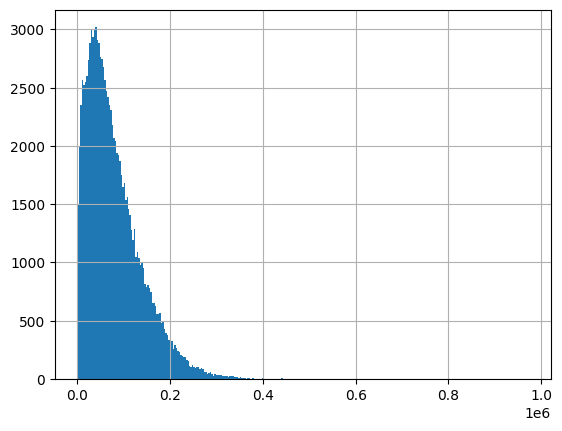

In [16]:
client_behave_trace.duration.hist(bins="auto")
plt.show()

The subsequent distribution should show us how different the activity cycles recorded in the traces are. Due to the considerable variation in finish times, it was necessary to use the `finish_time` as a normalisation factor above to simulate devices operating in the same period.


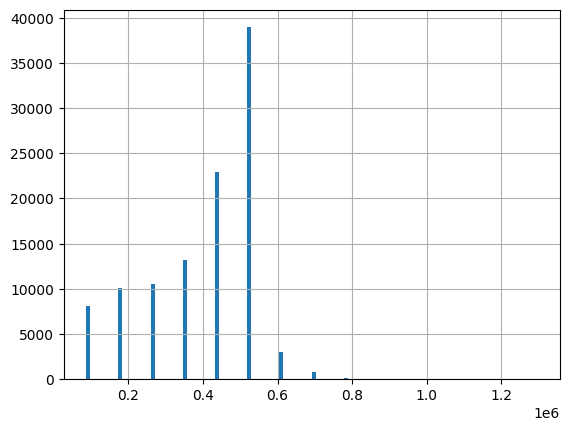

In [17]:
client_behave_trace.finish_time.hist(bins="auto")
plt.show()

One of the choices we had to make when modelling client activity concerned handling the period between 0 and when a client first becomes active; we can now inspect the motivating factors behind treating that period as inactive.

Our choice was theoretically justifiable and practical given the start-times distribution we see below. The peak around 0 is natural, given that this was when the recording started. However, it may create difficulties during FL simulations as it would allow many clients to be available immediately for the first few rounds. Additionally, as all clients would be right at the beginning of their active period for the first round, it would create a scenario with minimal drop-out rates.

> By treating everyone who starts later than 0 as inactive at the start, we lower the potential bias towards the early rounds that a simulation may have.


In [18]:
client_behave_trace

,duration,inactive,finish_time,active,model
1,972262,"[59046, 87718, 161219, 1081886]",1123200,"[51490, 60870, 140727, 164520]",LG-K350
2,691032,"[12823, 658127, 685128, 715053, 765786, 843740...",950400,"[10596, 12885, 683099, 713791, 750327, 834323,...",CPH1909
3,683891,"[109, 4829, 5790, 6531, 7062, 7103, 8804, 9704...",864000,"[36, 112, 5575, 6283, 6905, 7077, 7104, 9233, ...",TA-1028
4,666351,"[4085, 6176, 9002, 10072, 450772, 478872, 4818...",950400,"[3266, 5750, 8838, 9382, 11012, 450831, 479288...",SM-A207F
5,597218,"[437679, 437702, 437716, 437778, 437795, 43792...",691200,"[0, 437681, 437703, 437722, 437778, 437798, 43...",RMX1811
...,...,...,...,...,...
107745,1,[1],432000,[0],Redmi Note 5A
107746,1,[252122],518400,[252121],SM-T810
107747,1,[178673],518400,[178672],FRD-L19
107748,1,[1],86400,[0],SM-G920F


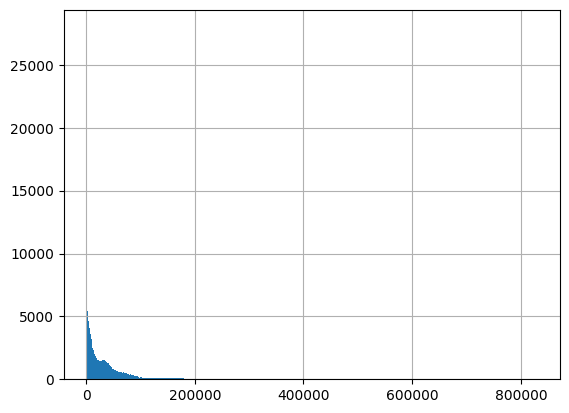

In [19]:
# New column containing the start time of
# each client defined as the beginning
# of their first active period
client_behave_trace["first_active"] = client_behave_trace["active"].map(lambda x: x[0])
client_behave_trace.first_active.hist(bins="auto")
plt.show()

**Question 5 (Part II ✅ | Part III/MPhil ✅):**

(You need to provide the answer with **code** and **plots** for this question. A short written argumentation is recommended.)

1. Randomly sample 100 behavioural traces from `client_behave_trace`. Sample without replacement. Plot the total number of active and inactive clients over time for 600000 seconds using steps of 10 seconds.
2. Sort `client_behave_trace` by `finish_time` in **ascending** order. Call it `ft_sorted_client_behave`. Repeat point (1) using `ft_sorted_client_behave` instead of `client_behave_trace`. Replace the random sampling with a sampling of the first 100 traces.
3. Sort `client_behave_trace` by `duration` in **descending** order. Call it `dur_sorted_client_behave`. Repeat point (1) using `dur_sorted_client_behave` instead of `client_behave_trace`. Replace the random sampling with a sampling of the first 100 traces.
4. Compare the three plots. What do you observe? What are the implications of performing FL with such populations?


Question 5

1. This code is the crux of the problem. The approach is creating a function that plots the required quantities for any dataframe
    - We create counters for both the active and invalid clients for every bin of `step` seconds from 0 seconds until time `T`.
    - For each bin, starting at time `t = i * step`, we loop through all the clients and look for the largest active and inactive values up to time `t`. If the latest update from the model was saying that it became active, we increment the `active` counter, otherwise we increment the `inactive` counter.
        - For efficiency purposes, we use `np.searchsorted` to use binary search on the finish times, as they are all sorted by default. (Note that we verify this assumption in the method)
    - From here, we just pass the appropriate `DataFrames` for problems 1, 2, 3.
    - Note, that we could have used the `is_active` function provided to us, but that would sort the active arrays every time, leading to considerable performance losses. I have left code using that approach as a comment below.


<div hidden></div>


4. We see that most of the population is inactive at any time, with some clients stopping pretty early on, whereas some clients continue contributing throughout the entire process. This means that we might "forget" the data coming from the early clients throughout the optimisation for later steps, and we might overfit to the data from the clients who have been around for the entire time.

In [20]:
def plot_active_inactive(df, T=600000, step=10):
    active_cnt = [0 for _ in range(T // step)]
    inactive_cnt = [0 for _ in range(T // step)]

    active_rows = df.active.map(np.array)
    inactive_rows = df.inactive.map(np.array)

    assert active_rows.map(lambda a: np.all(a[:-1] <= a[1:])).all()
    assert inactive_rows.map(lambda a: np.all(a[:-1] <= a[1:])).all()

    for i in tqdm(range(0, T // step)):
        # This is an easier approach using `is_active`, that we decided against, as it is less efficient
        # active_cnt[i] = df.apply(is_active, current_clock_time = i*step, axis=1).sum()
        # inactive_cnt[i] = len(df) - active_cnt[i]
        for active, inactive in zip(active_rows, inactive_rows):
            max_active = np.searchsorted(active, i * step, side="right")
            max_inactive = np.searchsorted(inactive, i * step, side="right")

            if max_active > max_inactive:
                active_cnt[i] += 1
            else:
                inactive_cnt[i] += 1

    sns.lineplot(
        pd.DataFrame([active_cnt, inactive_cnt], index=["active", "inactive"]).T
    )

100%|███████████████████████████████████| 60000/60000 [00:12<00:00, 4763.07it/s]


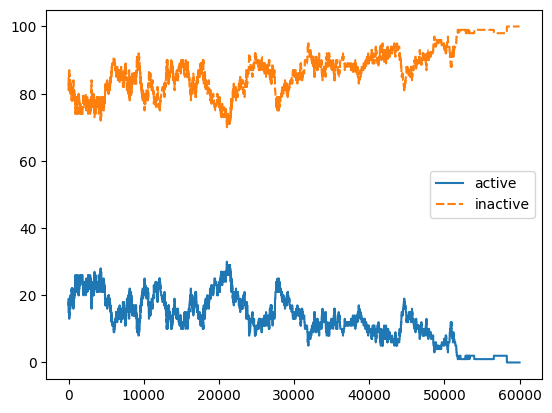

In [21]:
plot_active_inactive(client_behave_trace.sample(100, replace=False, random_state=42))

100%|███████████████████████████████████| 60000/60000 [00:12<00:00, 4856.47it/s]


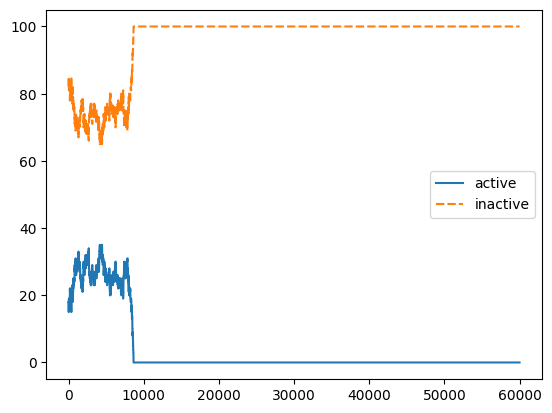

In [22]:
ft_sorted_client_behave = client_behave_trace.sort_values(
    by=["finish_time"], ascending=True
)
plot_active_inactive(ft_sorted_client_behave.iloc[:100])

100%|███████████████████████████████████| 60000/60000 [00:12<00:00, 4739.99it/s]


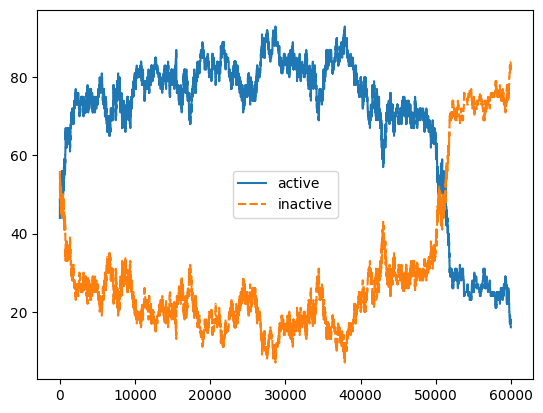

In [23]:
dur_sorted_client_behave = client_behave_trace.sort_values(
    by=["duration"], ascending=False
)
plot_active_inactive(dur_sorted_client_behave.iloc[:100])

**Question 6 (Part III/MPhil ✅):**

(This is meant to be a conceptual question. You should provide a written answer to this. **No more than 3 sentences each**. **No code** is needed)

1. In light of your consideration about question (5) above, what do you think could happen when reverting the ordering in point (2) and point (3)? Focus on the plots.
2. What are the implications of the FL training with such populations? Refer to populations with reverse ordering in point (2) and point (3).


### Analyse what's inside device capabilities


In the next few cells, we will analyse the content of `client_device_trace`.
Primarily, we will focus on the distribution of `computation` and `communication` on the clients and the afferent trade-off between the two, given a specific model size.


As we could have imagined, the devices' computational capabilities are highly heterogeneous. For example, despite the consistent peak at around 25 ms/sample, there is a relevant part of the population of devices with values 6 to 8 times higher. Suppose such heterogeneity in computation was related to factors influencing the data distribution. In that case, it could induce significant bias in the model training procedure, which would have to be considered by the developer.


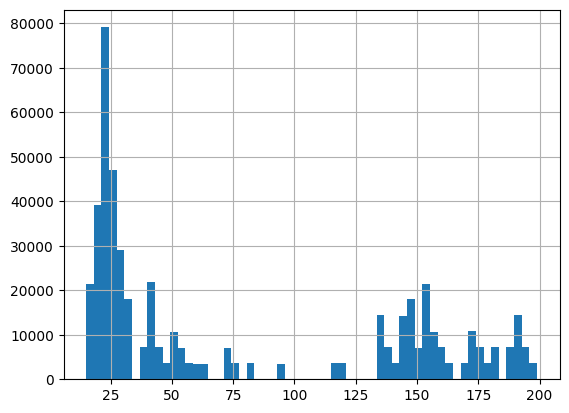

In [24]:
client_device_capacity.computation.hist(bins="auto")
plt.show()

The communication capabilities are also very heterogeneous, as expected. Despite the distribution having a more apparent peak with a shorter tail, some devices have communication capabilities orders of magnitude higher than the peak of the distribution.

Geographic variance in network speed is non-uniform and related to the data a given client may contain.


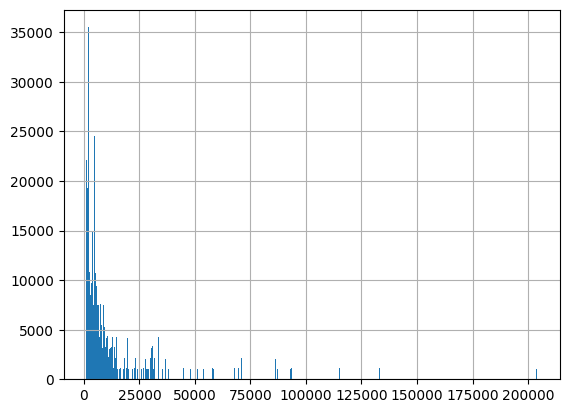

In [25]:
client_device_capacity.communication.hist(bins="auto")
plt.show()

In [26]:
client_device_capacity.communication.mean()

13736.140238980068

As you may have previously noticed, the traces for the device compute capabilities and the traces for availability are uncorrelated. This is due to a lack of datasets in FL which synchronously cover both.

In the following question you will be asked to numerically verify this lack of correlation. 

**Question 7 (Part II ✅):**

(You need to provide the answer with **code** and **plots** for this question. A short written argumentation is recommended.)

Looking carefully at the number in the y-axis, some of you may have noticed that the number of samples retrieved from `client_behave_trace` is not the same as that retrieved from `client_device_capacity`. Given this fact, we may wish to investigate if they are drawn from the same population of devices.

1. Plot communication and computation mapped one-to-one using the entirety of `client_device_capacity`.

- Do you notice any correlation between the two traces as given?

2. Fix two different thresholds for computation, and plot the histogram of communication costs from the previous mapping using only traces whose computation falls below the given threshold.

- Do these histograms look different from one another?
- Do they look different from the overall communication histogram?

3. Fix two communication thresholds and plot the histograms of computation costs of traces with communication values falling below the thresholds.

- Do these histograms look different from one another?
- Do they look different from the overall computation histogram?


Question 7.

1. I use `sns.regplot` to try plot the scatterplot and fit the line of best fit. It seems that there is no apparent correlation looking only at the scatterplot, but if we bin the devices into 100 bins by the communication capabilities, we can notice how the means of the bins seems to have a positive correlation.

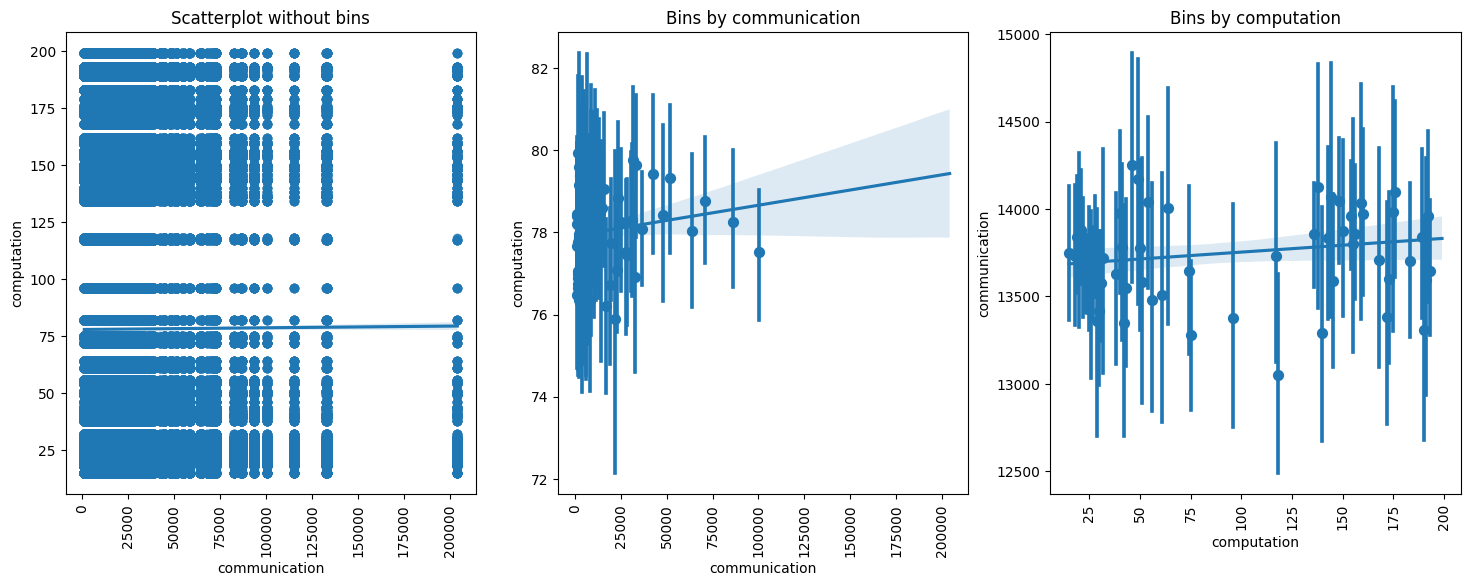

In [27]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
sns.regplot(
    client_device_capacity, x="communication", y="computation", ax=ax[0]
).set_title("Scatterplot without bins")
sns.regplot(
    client_device_capacity, x="communication", y="computation", x_bins=100, ax=ax[1]
).set_title("Bins by communication")
sns.regplot(
    client_device_capacity, x="computation", y="communication", x_bins=100, ax=ax[2]
).set_title("Bins by computation")

for axx in ax:
    axx.tick_params(axis="x", rotation=90)

2. I first filter the dataframes, then use `pd.DataFrame.hist` to plot the values. The plots look fairly similar, even if I try zooming in by taking a log scale.

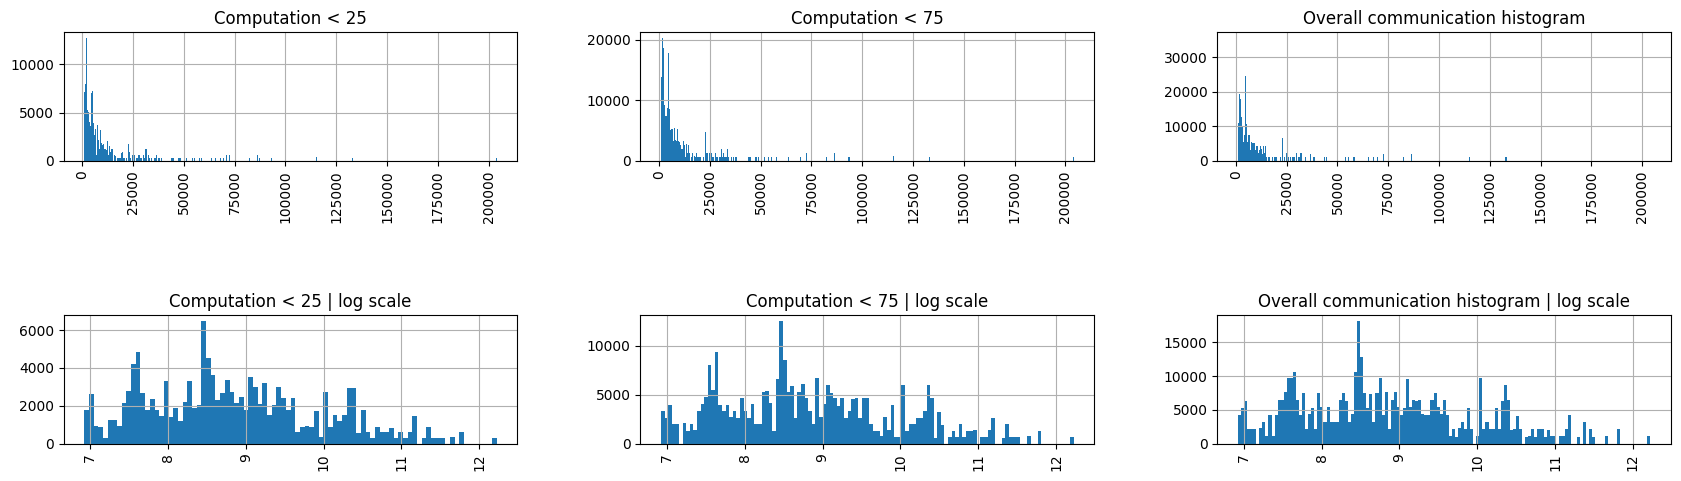

In [28]:
fig, ax = plt.subplots(2, 3, figsize=(18, 6))
client_device_capacity.pipe(lambda df: df[df["computation"] < 25]).communication.hist(
    bins="auto", ax=ax[0][0]
).set_title("Computation < 25")
client_device_capacity.pipe(lambda df: df[df["computation"] < 75]).communication.hist(
    bins="auto", ax=ax[0][1]
).set_title("Computation < 75")
client_device_capacity.communication.hist(bins="auto", ax=ax[0][2]).set_title(
    "Overall communication histogram"
)
client_device_capacity.pipe(lambda df: df[df["computation"] < 25]).communication.pipe(
    np.log
).hist(bins="auto", ax=ax[1][0]).set_title("Computation < 25 | log scale")
client_device_capacity.pipe(lambda df: df[df["computation"] < 75]).communication.pipe(
    np.log
).hist(bins="auto", ax=ax[1][1]).set_title("Computation < 75 | log scale")
client_device_capacity.communication.pipe(np.log).hist(
    bins="auto", ax=ax[1][2]
).set_title("Overall communication histogram | log scale")

for axx in ax:
    for axxx in axx:
        axxx.tick_params(axis="x", rotation=90)

plt.tight_layout(pad=5)

3. I use the same method as in the previous plot. The thresholds were found to be around the 25th and 50th percentile. The resulting hist plots still look very similar, even with their logs. It seems that as communication goes up, the tails of the computation distribution become more prominent, as seen on the log scale. This could result in more variance over the entire population.

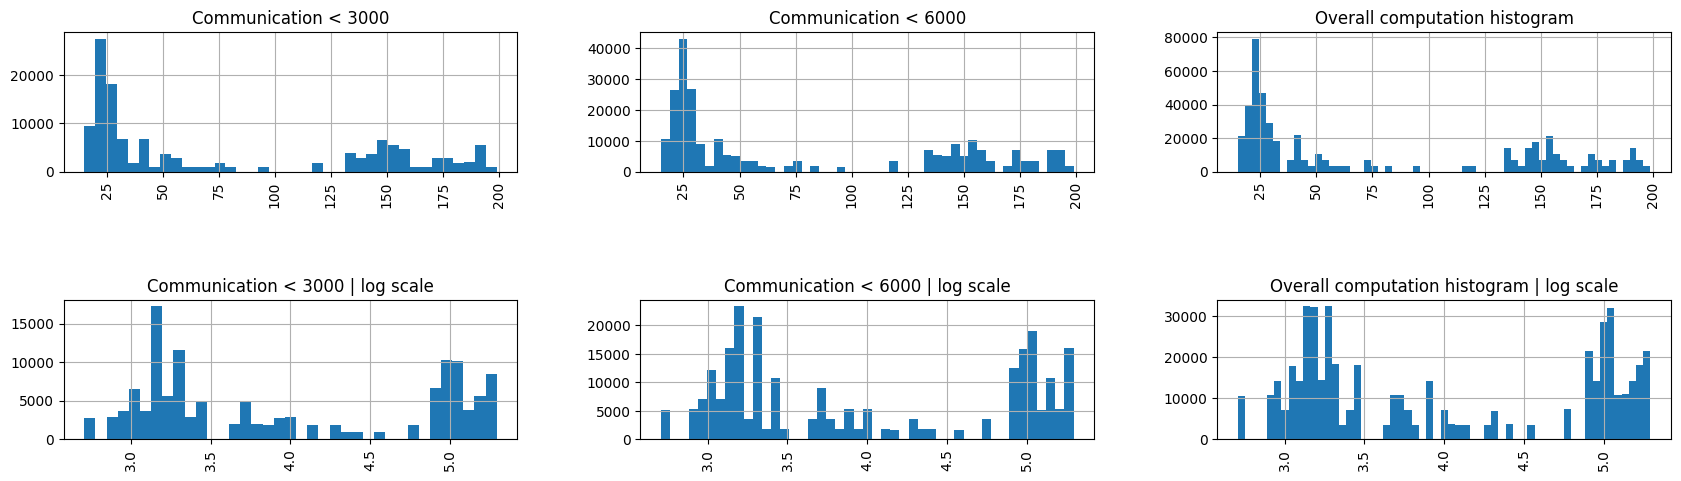

In [29]:
fig, ax = plt.subplots(2, 3, figsize=(18, 6))
client_device_capacity.pipe(lambda df: df[df["communication"] < 3000]).computation.hist(
    bins="auto", ax=ax[0][0]
).set_title("Communication < 3000")
client_device_capacity.pipe(lambda df: df[df["communication"] < 6000]).computation.hist(
    bins="auto", ax=ax[0][1]
).set_title("Communication < 6000")
client_device_capacity.computation.hist(bins="auto", ax=ax[0][2]).set_title(
    "Overall computation histogram"
)
client_device_capacity.pipe(lambda df: df[df["communication"] < 3000]).computation.pipe(
    np.log
).hist(bins="auto", ax=ax[1][0]).set_title("Communication < 3000 | log scale")
client_device_capacity.pipe(lambda df: df[df["communication"] < 6000]).computation.pipe(
    np.log
).hist(bins="auto", ax=ax[1][1]).set_title("Communication < 6000 | log scale")
client_device_capacity.computation.pipe(np.log).hist(
    bins="auto", ax=ax[1][2]
).set_title("Overall computation histogram | log scale")

for axx in ax:
    for axxx in axx:
        axxx.tick_params(axis="x", rotation=90)

plt.tight_layout(pad=5)

The mismatch between the two types of traces is because the authors of FedScale have combined two separate datasets to construct the files. They used [AI benchmark](https://arxiv.org/abs/1910.06663) to obtain the performance capabilities of mobile devices and [MobiPerf](https://www.measurementlab.net/tests/mobiperf/) to gather the availability traces.

Similarly to the mismatch between traces and data we have previously discussed, experiments using performance and availability traces collected from separate devices may not generalise to the real world. However, since we do not yet have the large-scale datasets necessary to model FL systems accurately, we will have to accept this inconsistency.


In [30]:
log(
    INFO,
    "The number of samples in `client_behave_trace` is %s",
    len(client_behave_trace),
)
log(
    INFO,
    "The number of samples in `client_device_capacity` is %s",
    len(client_device_capacity),
)

Because the clients do not come from the same population, we need to devise a method for synchronising them.
The most straightforward procedure we can devise is to sample `len (client_behave_trace)` data points from `client_device_capacity` uniformly. Many other methods that can extract distributions with particular characteristics are possible, but we will do this for brevity.


In [31]:
client_device_capacity = client_device_capacity.sample(
    len(client_behave_trace), replace=False, random_state=Seeds.DEFAULT
)
log(
    INFO,
    "The `client_device_capacity` obtained is %s",
    client_device_capacity,
)

We can plot the distributions from `client_device_capacity` to see if the sampling procedure has succeeded before we apply it in our experiments.


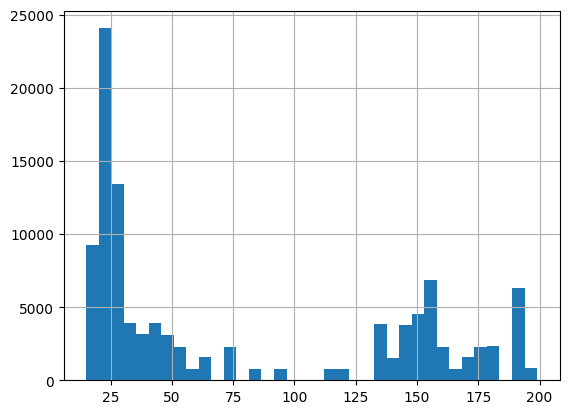

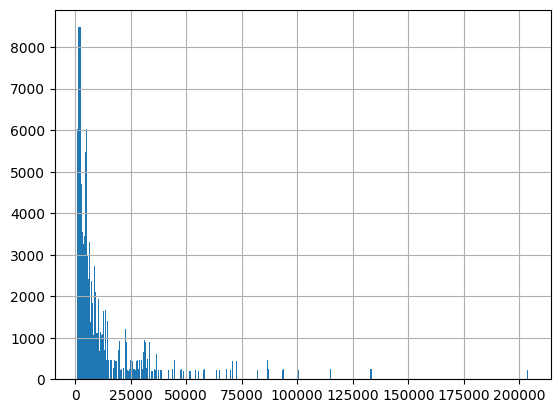

In [32]:
client_device_capacity.computation.hist(bins="auto")
plt.show()
client_device_capacity.communication.hist(bins="auto")
plt.show()

For later experiments, you will have to use a computation threshold to select clients. The following plot is likely the most revealing if you wish to understand better the impact a particular computation threshold will have on the number of clients that may be included in a given round. Pay particular attention to the sharp increase at the start of the plot.


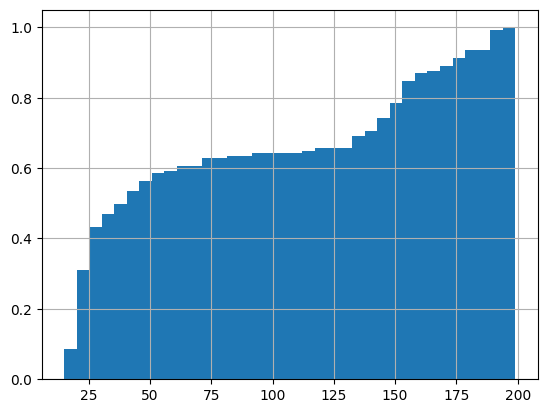

In [33]:
client_device_capacity.computation.hist(bins="auto", cumulative=True, density=True)
plt.show()

**Question 8 (Part II ✅):**

(You need to provide the answer with **code** and **plots** for this question. A short written argumentation is recommended.)

We have just extracted and analysed the device capabilities of our population and obtained some idea about how communication and computation capabilities are distributed. However, the exact trade-off depends on `model_size`, `batch_size` and `n_batches`. Since `batch_size*n_batches` is fixed to equal the local dataset size, `model_size` requires closer attention for our modelling of FL systems to be informative. Specifically, we want both communication and computation to have detectable impacts on your FL experiments and their interaction shifts as you scale a network.

Our function `get_client_completion_time` can help us observe the trade-off between computation and communication without running costly FL experiments. For the following question, assume that `batch_size=32`, `n_batches=64` stay fixed.

1. Compute the average client completion time for different values of `model_size`. The average is intended to be over the population described by `client_device_capacity`. Choose at least 100 different values of the `model_size` in the interval `[0,2000] MB`.
2. Plot your results from (1) as explained here: from (1) you will have the average communication latency (`a`), the average computation latency (`b`), and you can compute their sum (`c`). Then, plot those three curves (`a`, `b`, and `c`) in the same graph VS model size. The intersection point between `a` and `b` must be visible. What does it represent?
3. Extract the model size from the intersection point in (2).

> **You are required** to use the intersection parameter throughout the rest of this work.


Question 1.

1. I use `pd.apply` to get the row-wise application of the function, then call `pd.json_normalize` to create a `DataFrame` from the `Series` with `Dict` elements. I save the `DataFrame` of computation times for each size in a dictionary into `completion_times`, then I compute the average values for each size, and concatenate them using `pd.concat`. The result is saved in `avg_completion_times`.

In [34]:
BATCH_SIZE = 32
N_BATCHES = 64

completion_times = {}

for size in tqdm(np.linspace(0, 2000, num=100)):
    size = round(size)
    completion_times[size] = pd.json_normalize(
        client_device_capacity.apply(
            get_client_completion_time,
            batch_size=BATCH_SIZE,
            n_batches=N_BATCHES,
            model_size=size,
            axis=1,
        )
    )


avg_completion_times = pd.concat(
    [v.mean() for v in completion_times.values()],
    copy=True,
    axis=1,
    names=["model_size"],
)
avg_completion_times.columns = map(round, completion_times.keys())
avg_completion_times = avg_completion_times.T.rename_axis(
    index=["model_size"], columns=["latency_type"]
)

avg_completion_times

100%|█████████████████████████████████████████| 100/100 [01:11<00:00,  1.39it/s]


latency_type,computation,communication
model_size,,
0,478.473387,0.000000
20,478.473387,9.526520
40,478.473387,19.053039
61,478.473387,29.055885
81,478.473387,38.582404
...,...,...
1919,478.473387,914.069550
1939,478.473387,923.596070
1960,478.473387,933.598915


2.

We first assign the total latency as a column to the `DataFrame` using `pd.DataFrame.assign`, then as the data is already in a `DataFrame`, we can simply call `pd.DataFrame.plot` 

<Axes: xlabel='model_size'>

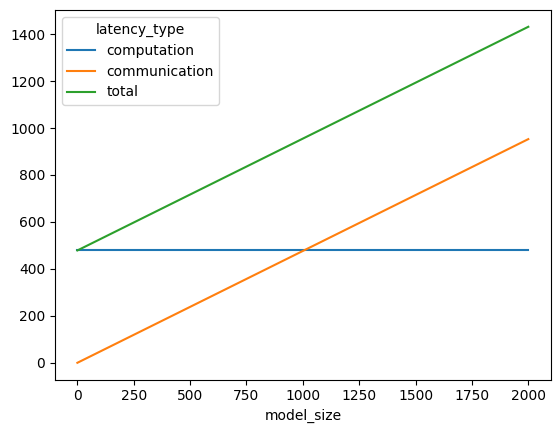

In [35]:
avg_completion_times.assign(total=lambda df: df.computation + df.communication).plot()

3. 

From the diagram it seems that the intersection point is about 1000. To find the exact point, we take the two points from our sample where the communication and computation time differences have the smallest absolute value, and see that they are indeed `990` and `1010`. Thus we can experiment a bit and find that `1004.508278` seems to make the times very close to each other.

In [36]:
avg_completion_times.pipe(
    lambda df: df.communication.sub(df.computation).abs()
).nsmallest(2)

model_size
1010    2.61585
990     6.91067
dtype: float64

In [37]:
opt_model_sz = 1004.508278

pd.json_normalize(
    client_device_capacity.apply(
        get_client_completion_time,
        batch_size=BATCH_SIZE,
        n_batches=N_BATCHES,
        model_size=opt_model_sz,
        axis=1,
    )
).mean()

computation      478.473387
communication    478.473387
dtype: float64

# 4. Implementing system traces in the simulation


To implement our system traces into the Flower simulator to model a real FL federation, we need to extend the abstraction of `FlowerRayClient`. The new version of the abstraction shall include the information we have extracted from the traces. Achieving this will require creating a new class `FlowerRayClientTraces`, which inherits from `FlowerRayClient`.

The new class will have minimal new attributes and functions needed to model the actual system accurately. We will simulate clients dropping out of the federation by throwing exceptions and allowing Flower to accept failures.

The `get_flower_client_generator` function will be modified to return a generator of `FlowerRayClientTraces` instead of `FlowerRayClient`. In addition, we will pass the traces that must be coupled to the clients as parameters.


## Implementation


We will also use previously unrevealed Flower features, such as client properties and criteria, so pay attention to those details. In short, clients can return properties to a criterion after they have been instantiated. The criterion then decides if the client should be included in the next federated round based on those properties.


In [38]:
class FlowerClientTraces(FlowerClient):
    """Extend the FlowerClient class to include traces and device capabilities."""

    def __init__(
        self,
        cid: int,
        data_dir: Path,
        partition_dir: Path,
        model_generator: Callable[[], Module],
        single_client_device_capacity: dict[str, Any],
        single_client_traces: dict[str, Any],
        verbose: bool = False,
    ) -> None:
        """Initialise the client.

        A Client is given a unique id and the directory from which it can load its data.
        Device capabilities and traces are also passed to the client.

        Args:
            data_dir (Path): path to the dataset folder.
            cid (int): Unique client id for a client used to map it to its data
                partition
            partition_dir (Path): The directory containing data for each client/client
                id
            model_generator (Callable[[], Module]): The model generator function
            single_client_device_capacity (dict[str, Any]): dictionary containing info
                about device capabilities.
            single_client_traces (dict[str, Any]): dictionary describing client device
                traces.
            verbose (bool): boolean describing whether the client should print or not.
        """
        super().__init__(cid, partition_dir, model_generator, data_dir)
        self.device_capacity = single_client_device_capacity
        self.trace = single_client_traces
        self.verbose = verbose
        self.properties: dict[str, Scalar] = {
            "tensor_type": "numpy.ndarray",
            "cid": self.cid,
            "device_capacity": self.device_capacity,
            "traces": self.trace,
        }

    def fit(
        self, parameters: NDArrays, config: dict[str, Scalar], **kwargs
    ) -> tuple[NDArrays, int, dict]:
        """Receive and train a model on the local client data.

        Also, the function checks if the client is active at the current time step.

        Args:
            net (NDArrays): Pytorch model parameters
            config (Dict[str, Scalar]): Dictionary describing the training parameters

        Returns
        -------
            tuple[NDArrays, int, dict]: Returns the updated model, the size of the
                local dataset and other metrics
        """
        # We need to include model size to compute communications costs as part of our
        # systems-aware simulation. Importantly, since Flower now accepts failures this
        # will only cause the client to return a failure
        if "model_size" not in config:
            raise Exception("Model size not found in config")

        # We need to compute the number of samples in the training set
        # As such we set n_batches to the number of batches which the set contains
        completion_time = get_client_completion_time(
            single_client_device_capacity=self.device_capacity,
            batch_size=int(config["batch_size"]),
            n_batches=int(
                int(config["epochs"])
                * self.get_train_set_size()
                / int(config["batch_size"])
            ),
            model_size=float(config["model_size"]),
        )
        # Add up the communication and computation times
        total_time = completion_time["communication"] + completion_time["computation"]

        # Store the result in the trace
        self.trace["duration"] = total_time

        if self.verbose:
            log(
                INFO,
                "Client %s\n--------\n\t\t"
                "Current virtual clock time: %s\n\t\t"
                "Duration: %s\n\t\t"
                "Traces: %s\n\t\t"
                "Predicted completion: %s\n\t\t"
                "Active: %s\n--------\n",
                self.cid,
                config["current_virtual_clock"],
                total_time,
                self.trace,
                int(config["current_virtual_clock"]) + int(total_time),
                is_active(
                    self.trace, int(config["current_virtual_clock"]) + int(total_time)
                ),
            )
        if "current_virtual_clock" not in config:
            raise IntentionalDropoutError("Current virtual clock not found in config")
        if not is_active(
            self.trace, int(config["current_virtual_clock"]) + int(total_time)
        ):
            raise IntentionalDropoutError(
                f"Client {self.cid} is not active at the current time step"
            )

        n_samples = len(self._create_data_loader(config, "train"))

        # NOTE: We do not need to train for this experiments
        # params, n_samples, results = super().fit(parameters, config)
        results = {
            "client_completion_time": total_time,
            "computation": self.device_capacity["computation"],
            "communication": self.device_capacity["communication"],
            "num_samples": n_samples,
            "cid": self.cid,
        }

        return parameters, n_samples, results

    def evaluate(
        self, parameters: NDArrays, config: dict[str, Scalar], **kwargs
    ) -> tuple[float, int, dict]:
        """Receive and test a model on the local client data.

        Also, the function checks if the client is active at the current time step.

        Args:
            net (NDArrays): Pytorch model parameters
            config (Dict[str, Scalar]): Dictionary describing the testing parameters

        Returns
        -------
            tuple[float, int, dict]: Returns the loss accumulate during testing, the
                size of the local dataset and other metrics such as accuracy
        """
        if "model_size" not in config:
            raise Exception("Model size not found in config")

        # Estimate time based on number of batches in dataset
        completion_time = get_client_completion_time(
            single_client_device_capacity=self.device_capacity,
            batch_size=int(config["batch_size"]),
            n_batches=int(self.get_test_set_size() / int(config["batch_size"])),
            model_size=float(config["model_size"]),
        )

        # Compute total time
        total_time = completion_time["communication"] + completion_time["computation"]

        # Store result in trace
        self.trace["duration"] = total_time
        if self.verbose:
            log(
                INFO,
                "Client %s\n--------\n\t\t"
                "Current virtual clock time: %s\n\t\t"
                "Duration: %s\n\t\t"
                "Traces: %s\n\t\t"
                "Predicted completion: %s\n\t\t"
                "Active: %s\n--------\n",
                self.cid,
                config["current_virtual_clock"],
                total_time,
                self.trace,
                int(config["current_virtual_clock"]) + int(total_time),
                is_active(
                    self.trace, int(config["current_virtual_clock"]) + int(total_time)
                ),
            )
        if "current_virtual_clock" not in config:
            raise IntentionalDropoutError("Current virtual clock not found in config")
        if not is_active(
            self.trace, int(config["current_virtual_clock"]) + int(total_time)
        ):
            raise IntentionalDropoutError(
                f"Client {self.cid} is not active at the current time step"
            )

        n_samples = len(self._create_data_loader(config, "test"))

        # NOTE: We do not need to train for this experiments
        # params, n_samples, results = super().fit(parameters, config)
        results = {
            "client_completion_time": total_time,
            "computation": self.device_capacity["computation"],
            "communication": self.device_capacity["communication"],
            "num_samples": n_samples,
            "cid": self.cid,
        }

        return 0.0, n_samples, results

In [39]:
def get_flower_client_with_traces_generator(
    clients_device_capacity: list[dict[str, Any]],
    clients_traces: list[dict[str, Any]],
    model_generator: Callable[[], Module],
    data_dir: Path,
    partition_dir: Path,
    mapping_fn: Callable[[int], int] | None = None,
) -> Callable[[str], FlowerClient]:
    """Wrap the client instance generator.

    This provides the client generator with a model generator function.
    Also, the partition directory must be passed.
    A mapping function could be used for filtering/ordering clients.

    Args:
        clients_device_capacity (list[dict[str, Any]]): list containing the clients
            device capabilities.
        clients_traces (list[dict[str, Any]]): list containing the clients traces.
        data_dir (Path): path to the datasßet folder.
        model_generator (Callable[[], Module]): model generator function.
        partition_dir (Path): directory containing the partition.
        mapping_fn (Callable[[int], int] | None): function mapping sorted/filtered
            ids to real cid.

    Returns
    -------
        Callable[[str], FlowerClient]: client instance.
    """

    def client_fn(cid: str) -> FlowerClientTraces:
        """Create a single client instance given the client id `cid`.

        Args:
            cid (str): client id, Flower requires this to of type str.

        Returns
        -------
            FlowerRayClientTraces: client instance.
        """
        log(INFO, "Getting client with id %s", cid)
        client = FlowerClientTraces(
            # NOTE: passing the called `cid` here to allow for different mapping between
            # data and devices
            single_client_device_capacity=clients_device_capacity[int(cid)],
            single_client_traces=clients_traces[int(cid)],
            # NOTE: the mapping is only applied here, this is due to control the data
            # mapping
            cid=(mapping_fn(int(cid)) if mapping_fn is not None else int(cid)),
            data_dir=data_dir,
            partition_dir=partition_dir,
            model_generator=model_generator,
            # NOTE: you may want to comment out the following line or to set the
            # verbosity to False
            verbose=False,
        )

        client.device = get_device()
        return client

    return client_fn

# 5. Setting up selection criteria


Selection criteria in FL may be varied; examples of such criteria include:

1. The client's hardware capabilities; if they cannot train a given model (i.e., they lack a necessary accelerator), they should not be selected.
2. Network and battery conditions; if the client is a phone which lacks access to power and free Wi-Fi, it should not be selected.
3. Statistical utility; if a client seems likely to have data which interests us---based on previous selection or other characteristics such as provenance region---it should be selected to the detriment of other clients.

> This lab shall focus on the first type of criteria. However, we shall build correlations between statistical utility and computational ability throughout to test how their inter-connection **could** impact FL under various assumptions.


## Implement selection criteria using the Criterion object


In the following cell, an example of a `Criterion` object is provided.
Note that this does not discriminate between clients beyond checking their availabilities, but it is still helpful to understand how it functions. For later questions, you may desire to impose a selection criterion in your client selection based on this template.

Be aware that using one of these objects implies additional communication between the client and the server. However, we will assume in our modelling that this communication is near-immediate (constant relative to the client dataset size) and is not affecting the federation by any means.

It is worth mentioning that the potential design space of criteria in Flower is limited by the requirement of only communicating once with the client and only being able to receive data from the client's properties. These constraints make it impossible for the server to communicate data to the client at the criterion level so that the client may make dynamic decisions regarding participation. Furthermore, without a persistent communication channel, the criterion may become false before the round begins, and the client has no means of informing the server.

To overcome these limitations, it would be valuable to expand and enhance the current implementation that Flower has under the hood for a potential Part II project.


In [40]:
class TemplateCriterion(Criterion):
    """Implements the Template criterion."""

    def __init__(self, **kwargs: Any) -> None:
        """Initialize the Template criterion.

        Args:
            **kwargs (Any): additional arguments.
        """
        super().__init__(**kwargs)

        """
            Put here the logic to set global parameters
            for selection, s.a. thresholds.
        """

    def select(self, client: ClientProxy) -> bool:
        """Select the client that receives.

        Before selecting it, the function gets the `properties` of the client.

        Args:
            client (ClientProxy): client proxy to select.

        Returns
        -------
            bool: True if the client is selected, False otherwise.
        """
        request_properties: Config = {
            # Here goes the template of the client properties
            "tensor_type": "str",
            "cid": "str",
            "device_capacity": "Dict[str, Any]",
            "traces": "Dict[str, Any]",
        }
        ins: GetPropertiesIns = GetPropertiesIns(config=request_properties)
        # NOTE: This `value` contains the client properties
        value: GetPropertiesRes = client.get_properties(ins, timeout=None)
        # NOTE: This object receives the current virtual clock from the server
        # in the CustomClientManager
        log(
            INFO,
            "TemplateCriterion.select: current clock is %s",
            self.current_virtual_clock,
        )

        """
            Put here the logic to select the client.
        """

        return True

Here follows the implementation of `ActivityCriterion`, a `Criterion` object that selects clients based on their activity evaluated at the selection time.

> Selecting clients using this does not guarantee they will not drop out during the local training phase.


In [41]:
class ActivityCriterion(Criterion):
    """Implements the a criterion based on the Activity."""

    def __init__(self) -> None:
        """Initialize the Template criterion."""
        self.current_virtual_clock = 0

    def select(self, client: ClientProxy) -> bool:
        """Select the client that receives if it is active.

        Before selecting it, the function gets the `properties` of the client.

        Args:
            client (ClientProxy): client proxy to select.

        Returns
        -------
            bool: True if the client is selected, False otherwise.
        """
        request_properties: Config = {
            # Here goes the template of the client properties
            "tensor_type": "str",
            "cid": "str",
            "device_capacity": "Dict[str, Any]",
            "traces": "Dict[str, Any]",
        }
        ins: GetPropertiesIns = GetPropertiesIns(config=request_properties)
        # NOTE: This contains the client properties
        value: GetPropertiesRes = client.get_properties(ins, timeout=None)
        # NOTE: here we use `is_active` to check if the client is active at the current
        # time step
        return is_active(value.properties["traces"], self.current_virtual_clock)

The following cell is meant to initialise the model.


In [42]:
torch.manual_seed(Seeds.DEFAULT)
network_generator_cnn = get_network_generator_cnn()
seed_net_cnn = network_generator_cnn()
seed_model_cnn_params: NDArrays = get_model_parameters(seed_net_cnn)

Given that you have determined the intersection point within the traces we use, it is reasonable to consider the actual size of our model in MB. For this, we shall use the `torchsummary` package.

> **KEEP USING THE INTERSECTION MB VALUE DETERMINED ABOVE**


In [43]:
import torchsummary

torchsummary.summary(
    seed_net_cnn.to(device if (device := get_device()) != "mps" else "cpu"),
    (1, 28, 28),
    device=device if (device := get_device()) != "mps" else "cpu",
)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 24, 24]             156
         MaxPool2d-2            [-1, 6, 12, 12]               0
            Conv2d-3             [-1, 16, 8, 8]           2,416
         MaxPool2d-4             [-1, 16, 4, 4]               0
            Linear-5                  [-1, 120]          30,840
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 62]           5,270
Total params: 48,846
Trainable params: 48,846
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.19
Estimated Total Size (MB): 0.23
----------------------------------------------------------------


As we can see, the network we have selected for demonstration purposes in this lab is tiny and should thus result in meagre communication costs relative to computation. However, the balance between computation and communication would likely not be so one-sided in a production system.

Thus far, we have treated the two costs as equivalent in terms of their impact on the overall training time of the FL system. However, the two are not always symmetrical in terms of costs. For example, if the entity running the federation does not own nor pay for the resources of the underlying devices---as is the case in many scenarios involving smartphones---then computation on-edge incurs zero monetary costs. At the same time, models' storage and transmission scales with the size and number of networks. Furthermore, while we only account for model size in the communication costs, a larger model requires more operations per training step and more training steps overall to train.

All of these factors guide FL to be biased towards using architectures with a lower footprint, reducing model size via quantisation, and clustering clients into small groups that have similar data---which a small network can quickly learn from.


Here the function to generate clients is provided. Note that if you want to use a different `client_device_capacity` or `client_behave_trace`, you need to change the parameters here and re-execute the cell.


In [44]:
# NOTE: we are using here the `get_flower_client_with_traces_generator`
num_total_clients = 3229
sampled_cdc = client_device_capacity.sample(
    num_total_clients, replace=False, random_state=Seeds.DEFAULT
).copy()
sampled_cbt = client_behave_trace.sample(
    num_total_clients, replace=False, random_state=Seeds.DEFAULT
).copy()
sampled_cbt.inactive = sampled_cbt.inactive.map(lambda l: list(map(lambda x: x + 1, l)))

flower_client_with_traces_generator: Callable[[str], FlowerClient] = (
    get_flower_client_with_traces_generator(
        clients_device_capacity=sampled_cdc.to_dict("records"),
        clients_traces=sampled_cbt.to_dict("records"),
        model_generator=network_generator_cnn,
        data_dir=data_dir,
        partition_dir=federated_partition,
    )
)

In [45]:
assert (
    sampled_cbt.explode(["active", "inactive"])
    .pipe(lambda df: (df[["active", "inactive"]].min(axis=1) < df.finish_time))
    .all()
)
assert sampled_cbt.explode(["active", "inactive"]).pipe(
    lambda df: (df.active < df.inactive).all()
)

The following cell contains the vast majority of the hyperparameters for the FL training. Notice the addition of a model size and virtual clock in the configs and the `accept_failures` = True` parameter.


In [46]:
train_config = get_default_train_config()
train_config.update(
    {
        "model_size": 1000,
        "current_virtual_clock": 0.0,
    }
)
test_config = get_default_test_config()
test_config.update(
    {
        "model_size": 1000,
        "current_virtual_clock": 0.0,
    }
)


def _on_fit_config_fn(server_round: int) -> dict[str, Scalar]:
    return train_config | {"server_round": server_round}


def _on_evaluate_config_fn(server_round: int) -> dict[str, Scalar]:
    return test_config | {"server_round": server_round}


num_clients_per_round: int = 3
num_evaluate_clients: int = 1
fraction_fit = sys.float_info.min
fraction_evaluate = sys.float_info.min
accept_failures = True
min_fit_clients = num_clients_per_round
min_available_clients = num_evaluate_clients
initial_parameters: Parameters = ndarrays_to_parameters(seed_model_cnn_params)

strategy = FedAvgTraces(
    fraction_fit=fraction_fit,
    fraction_evaluate=fraction_evaluate,
    min_fit_clients=min_fit_clients,
    min_available_clients=min_available_clients,
    on_fit_config_fn=_on_fit_config_fn,
    on_evaluate_config_fn=_on_evaluate_config_fn,
    initial_parameters=initial_parameters,
    accept_failures=accept_failures,
    evaluate_fn=None,
    fit_metrics_aggregation_fn=aggregate_weighted_average,
    evaluate_metrics_aggregation_fn=aggregate_weighted_average,
)

Since we have introduced a `Criterion` object, we need to use both a `Server` and a `ClientManager`. The `Server` orchestrates training over selected clients while the `ClientManager` is tasked with providing it with the lists of clients used for a given round. Consequently, they will wrap our `Criterion` with all the utilities to let the FL simulation use it.


In [47]:
criterion = ActivityCriterion()
custom_client_manager = CustomClientManager(criterion=criterion, seed=Seeds.DEFAULT)
server = Server(
    client_manager=custom_client_manager,
    strategy=strategy,
)

We may finally launch the simulation with enhanced abilities to select clients based on traces and to have them drop out according to their activity and execution duration.


In [48]:
model_params, hist = start_seeded_simulation(
    client_fn=lambda cid: flower_client_with_traces_generator(cid).to_client(),
    num_clients=num_total_clients,
    config=ServerConfig(num_rounds=10),
    server=server,
    strategy=strategy,
    name="activity_criterion",
)

Let us investigate the new history object you will use to determine the behaviour of your execution. Notice the addition of a completion time for each client, as they are meant to execute in parallel. The highest completion time represents the duration of a round. Our new strategy and criterion this principle to maintain the `current_virtual_clock`; you may investigate the implementation further by looking into the python files.


In [49]:
log(INFO, "Simulation results: %s", hist)

**Question 9 (Part II ✅):**

(You need to provide the answer with **code** and **plots** for this question. An extended written argumentation is recommended.)

Now that we can run a whole synchronised system-aware simulation, it is time we consider how different system characteristics can impact client availability and in-turn the distribution of data the model trains on.

1. Produce a random mapping between client IDs and traces, this mapping should be fixed and used across all rounds and experiments of this question.
2. Assume an FL setting whose total population is of 3229 clients and assume random sampling of 10 clients per round and 323 rounds.
3. Implement three different criteria to obtain the following three availability patterns respectively:
  - Pattern 1: Constant availability of 10 clients per round.
  - Pattern 2: Average availability of 8 clients per round.
  - Pattern 3: Average availability of 5 clients per round.
4. Support your implementation choices with both: (a) a priori discussion, (b) a discussion of the plots and results.



Question 9:

> Note: I was running everything locally in a virtual environment, so I needed to replace the `!pip install ...` snippets with `%pip install ...`.
I also needed to add a `%pip uninstall flwr` to the beginning to avoid a version mismatch where `FedAvgM` was raising the exceptions instead of returning None. (This is a fun error, as it's not in the docs.) I think adding these modifications to future versions could be useful. The setup code in this notebook works well for local execution too.

1. I create a sample of the client mappings that are indexed by the client IDs from `1` to `3229`.

In [50]:
client_mappings = client_behave_trace.sample(3229, random_state=19329).reset_index(
    drop=True
)
client_mappings

,duration,inactive,finish_time,active,model,first_active
0,79761,"[22884, 32663, 55565, 156222, 219030, 255350, ...",432000,"[20605, 28709, 43866, 129030, 215285, 248963, ...",SM-A107M,20605
1,58342,"[15415, 41116, 46882, 48992, 57455, 59994, 127...",259200,"[14461, 41065, 45756, 48391, 53980, 57457, 126...",ANE-LX3,14461
2,67758,"[37802, 124110, 177458, 254238, 263690, 263763...",518400,"[32297, 118929, 172891, 250469, 262060, 263691...",ASUS_Z017DB,32297
3,56485,"[99331, 145808, 181589, 183217, 239076, 247978...",345600,"[92906, 137561, 177072, 182161, 237389, 247959...",SM-J730G,92906
4,104933,"[195, 18067, 28668, 32153, 45869, 46193, 46277...",259200,"[0, 195, 26461, 30067, 42880, 46096, 46194, 46...",F1fw,0
...,...,...,...,...,...,...
3224,94495,"[69074, 91938, 137622, 152895, 178255, 217107,...",518400,"[64306, 82501, 136967, 145893, 168940, 217048,...",RMX1941,64306
3225,178205,"[778, 3438, 5448, 9272, 15401, 38460, 81806, 8...",518400,"[0, 879, 3776, 5456, 10514, 19323, 80938, 8410...",Redmi Note 3,0
3226,188162,"[26562, 65958, 114909, 157185, 166283, 167114,...",518400,"[0, 53703, 83568, 157027, 162407, 166626, 1759...",CPH1909,0
3227,11588,[89523],518400,[77935],SM-M205G,77935


2. 

In [51]:
N_CLIENTS = 3229
N_ROUNDS = 323
N_CLIENTS_PER_ROUND = 10

3. 

We create a class, `AverageAvailabilityCriterion`. This aims to keep the average number of active clients appropriate. Note that selecting $x$ active clients and $n-x$ inactive clients is **just a heuristic**, as clients drop out during the selection phase.  
To counter this, we try to come up with a smarter solution:
- The criterion knows the amount of active and inactive clients in each round
- It selects `num_active` active clients at selection time and `num_inactive` inactive clients.
- It knows when it advances to the next round, as its `current_virtual_clock` gets updated every round.
    - We use this to conduct a post-round analysis:
        - When we enter a new round, we check all clients that we selected in the previous round, whether they were active in the previous round or are active at the current one. *We assume that clients who are active at prev_virtual_clock and current_virtual_clock are the only ones returning successes*. This is an overestimate, as seen later on the plots.
        - We keep count of the successes and failures, and if we have more successes than needed, we just select `num_active` active clients at selection time and `num_inactive` inactive clients, as active clients are more likely to drop out and drag the local average down.
        - If the average is lower than desired, we choose 10 active clients to try pushing the average up.   
- Looking at the plots, it seems that this is somewhat of an overestimate.

In [192]:
class AverageAvailabilityCriterion(Criterion):
    """Implements the a criterion based on the Activity."""

    def __init__(self, num_active, num_inactive) -> None:
        """Initialize the Template criterion."""
        self.current_virtual_clock = 0
        self.num_active = num_active
        self.num_inactive = num_inactive
        self.true_mean_active = num_active / (num_active + num_inactive)
        self.successes = 0
        self.total = 0
        self.mean_active = self.true_mean_active
        self._reset()

    def _reset(self):
        self.prev_virtual_clock = self.current_virtual_clock
        self.actives = []
        self.inactives = []

    def _post_round_analysis(self):
        self.total += len(self.actives) + len(self.inactives)
        # If something didn't drop out during the local phase, it is still active
        self.successes += len(
            [
                client
                for client in self.actives
                if is_active(client, self.current_virtual_clock)
            ]
        )
        self.mean_active = self.successes / self.total

    def _start_next_round(self):
        self._post_round_analysis()
        self._reset()

    def select(self, client: ClientProxy) -> bool:
        """Always returns True"""
        if self.prev_virtual_clock < self.current_virtual_clock:
            self._start_next_round()

        request_properties: Config = {
            # Here goes the template of the client properties
            "tensor_type": "str",
            "cid": "str",
            "device_capacity": "Dict[str, Any]",
            "traces": "Dict[str, Any]",
        }
        ins: GetPropertiesIns = GetPropertiesIns(config=request_properties)
        # NOTE: This contains the client properties
        value: GetPropertiesRes = client.get_properties(ins, timeout=None)
        # NOTE: here we use `is_active` to check if the client is active at the current
        # time step
        active = is_active(value.properties["traces"], self.current_virtual_clock)
        if active and (self.mean_active < self.true_mean_active or 
             len(self.actives) < self.num_active
        ):
            self.actives.append(value.properties["traces"])
            return True
        elif (
            self.mean_active >= self.true_mean_active
            and not active
            and len(self.inactives) < self.num_inactive
        ):
            self.inactives.append(value.properties["traces"])
            return True
        return False

In [180]:
sampled_cdc = client_device_capacity.sample(
    N_CLIENTS, replace=False, random_state=1921381
)
sampled_cbt = client_behave_trace.sample(N_CLIENTS, replace=False, random_state=1921381)

flower_client_with_traces_generator: Callable[[str], FlowerClient] = (
    get_flower_client_with_traces_generator(
        clients_device_capacity=sampled_cdc.to_dict("records"),
        clients_traces=sampled_cbt.to_dict("records"),
        model_generator=network_generator_cnn,
        data_dir=data_dir,
        partition_dir=federated_partition,
    )
)

In [181]:
train_config = get_default_train_config()
train_config.update(
    {
        "model_size": 1000,
        "current_virtual_clock": 0.0,
        "num_workers": 0,
    }
)
test_config = get_default_test_config()
test_config.update(
    {
        "model_size": 1000,
        "current_virtual_clock": 0.0,
        "num_workers": 0,
    }
)


def _on_fit_config_fn(server_round: int) -> dict[str, Scalar]:
    return train_config | {"server_round": server_round}


def _on_evaluate_config_fn(server_round: int) -> dict[str, Scalar]:
    return test_config | {"server_round": server_round}


initial_parameters: Parameters = ndarrays_to_parameters(seed_model_cnn_params)

In [196]:
def fit_model(criterion):
    strategy = deepcopy(
        FedAvgTraces(
            fraction_fit=fraction_fit,
            fraction_evaluate=fraction_evaluate,
            min_evaluate_clients=N_CLIENTS_PER_ROUND,
            min_fit_clients=N_CLIENTS_PER_ROUND,
            min_available_clients=1,
            on_fit_config_fn=_on_fit_config_fn,
            on_evaluate_config_fn=_on_evaluate_config_fn,
            initial_parameters=initial_parameters,
            accept_failures=True,
            evaluate_fn=None,
            fit_metrics_aggregation_fn=aggregate_weighted_average,
            evaluate_metrics_aggregation_fn=aggregate_weighted_average,
        )
    )

    custom_client_manager = CustomClientManager(criterion=criterion, seed=Seeds.DEFAULT)
    server = Server(
        client_manager=custom_client_manager,
        strategy=strategy,
    )

    model_params, hist = start_seeded_simulation(
        client_fn=lambda cid: flower_client_with_traces_generator(cid).to_client(),
        num_clients=N_CLIENTS,
        config=ServerConfig(num_rounds=323),
        server=server,
        strategy=strategy,
        name="activity_criterion",
    )

    return model_params, hist

In [223]:
def plot_results(results):
    fig, ax = plt.subplots()
    sns.lineplot(
        [
            len(completion_time[1]["all"])
            for completion_time in results.metrics_distributed[
                "client_completion_time"
            ]
        ], ax=ax
    )

    min, max = ax.get_xlim()

    arr = np.array([
            len(completion_time[1]["all"])
            for completion_time in results.metrics_distributed[
                "client_completion_time"
            ]
    ])

    ax.fill_between(np.arange(min, max), arr.mean() - arr.std(), arr.mean() + arr.std(), color='orange', alpha=0.8)
    
    ax.axhline(arr.mean(), color='black', linestyle='--')

    print(f"Mean: {arr.mean()}")
    return ax

In [201]:
constant_params, constant_hist = fit_model(AverageAvailabilityCriterion(10, 0))

Mean: 9.340557275541796


Text(0.5, 1.0, 'Constant 10 availability | availability at local testing time')

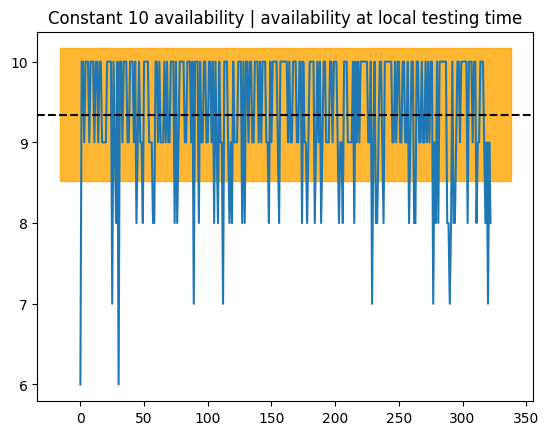

In [225]:
plot_results(constant_hist).set_title('Constant 10 availability | availability at local testing time')

In [197]:
available_params, available_hist = fit_model(AverageAvailabilityCriterion(8, 2))

Mean: 9.037151702786378


Text(0.5, 1.0, 'Average 8 availability | availability at local testing time')

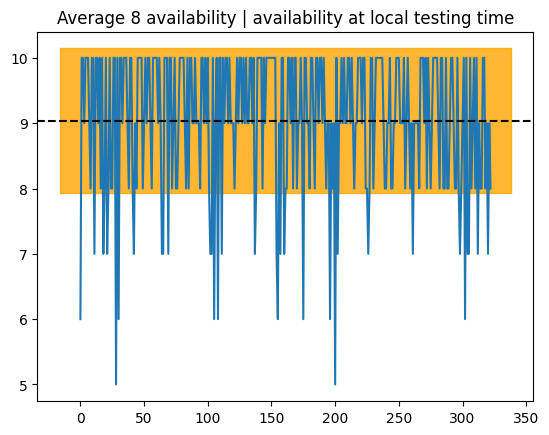

In [226]:
plot_results(available_hist).set_title('Average 8 availability | availability at local testing time')

In [199]:
unreliable_params, unreliable_hist = fit_model(AverageAvailabilityCriterion(5, 5))

Mean: 5.613003095975232


Text(0.5, 1.0, 'Average 5 availability | availability at local testing time')

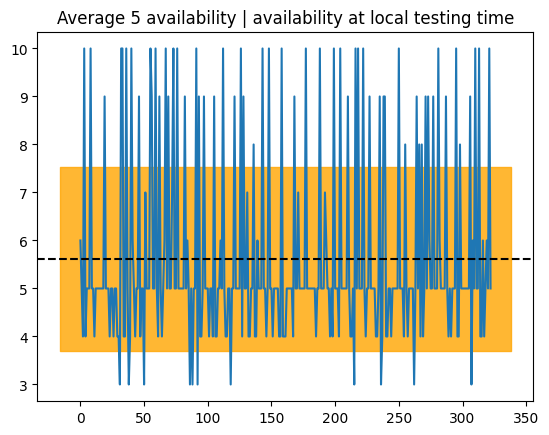

In [227]:
plot_results(unreliable_hist).set_title('Average 5 availability | availability at local testing time')


(c) 2024 Alexandru-Andrei Iacob, Lorenzo Sani